# PTEN in Endo and GBM

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u

In [2]:
gbm = cptac.Gbm()
endo = cptac.Endometrial()

In [3]:
cancer1 = "GBM"
cancer2 = "Endometrial"
gene = 'PTEN'

In [4]:
#GBM ttest
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
prot = gbm.get_proteomics()
prot_list = list(prot.columns)
prot_and_mutations = gbm.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'proteomics', omics_genes = prot_list)  

# Step 2 - Create binary column 
prot_and_mutations['binary_mutations'] = np.where(
            prot_and_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

# Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
tumors = prot_and_mutations[prot_and_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status = mut_status.dropna(axis=1,how='all')

In [5]:
col_list = list(mut_status.columns)
col_list.remove('binary_mutations')

print("Doing t-test comparisons for GBM\n")

# Call wrap_ttest, pass in formatted dataframe
wrap_results = u.wrap_ttest(mut_status, 'binary_mutations', col_list, return_all=True)

Doing t-test comparisons for GBM



C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


No significant comparisons.


In [6]:
wrap_results.loc[wrap_results['Comparison'] == gene+"_proteomics"]

,Comparison,P_Value
0,PTEN_proteomics,0.000032


In [7]:
# endo ttest
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
prot2 = endo.get_proteomics()
prot_list2 = list(prot2.columns)
prot_and_mutations = endo.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'proteomics', omics_genes = prot_list2)  

# Step 2 - Create binary column 
prot_and_mutations['binary_mutations'] = np.where(
            prot_and_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

# Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
tumors = prot_and_mutations[prot_and_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status2 = mut_status.dropna(axis=1,how='all')

In [8]:
col_list2 = list(mut_status2.columns)
col_list2.remove('binary_mutations')

print("Doing t-test comparisons for Endometrial")

# Call wrap_ttest, pass in formatted dataframe
wrap_results2 = u.wrap_ttest(mut_status2, 'binary_mutations', col_list2, return_all=True)

Doing t-test comparisons for Endometrial
78 significant comparisons!


In [9]:
wrap_results2.loc[wrap_results2['Comparison'] == gene+"_proteomics"]

,Comparison,P_Value
7303,PTEN_proteomics,0.018255


In [10]:
#combine pval results
combined = wrap_results.merge(wrap_results2, on='Comparison')
combined = combined.replace(regex=True,to_replace='_proteomics', value='')

In [11]:
# Green = interacting protein
interacting_list = u.get_interacting_proteins(gene)
combined["color"] = np.where(combined["Comparison"].isin(interacting_list), "red", "lightblue")
print(interacting_list)
#combined.loc[combined['color'] == 'red']
both_values_df = combined.dropna(axis=0, how='any') # only keep rows with both data points
both_values_df

['MDM2', 'CSNK2A1', 'PDGFRB', 'PIK3R2', 'PIK3C3', 'CSNK2A2', 'SLC9A3R1', 'PIK3R3', 'USP13', 'PIK3CA', 'TP53', 'EGFR', 'PIK3CB', 'PTK2', 'USP7', 'XIAP', 'PTEN', 'PREX2', 'MAST2', 'PIK3CD', 'ROCK1', 'SHC1', 'NEDD4', 'INPP4B', 'PIK3R1', 'AKT1', 'MVP', 'MAGI3']


,Comparison,P_Value_x,P_Value_y,color
0,PTEN,0.000032,0.018255,red
1,CALD1,0.000227,0.831139,lightblue
2,FLNC,0.000240,0.987449,lightblue
3,ERBB2,0.000491,0.000164,lightblue
4,MAPK8IP3,0.000499,0.000446,lightblue
...,...,...,...,...
9792,METTL26,0.997759,0.049312,lightblue
9793,ZNF207,0.998493,0.406304,lightblue
9794,POLB,0.999058,0.050598,lightblue
9795,TIMM21,0.999198,0.182861,lightblue


Visualize all P-values

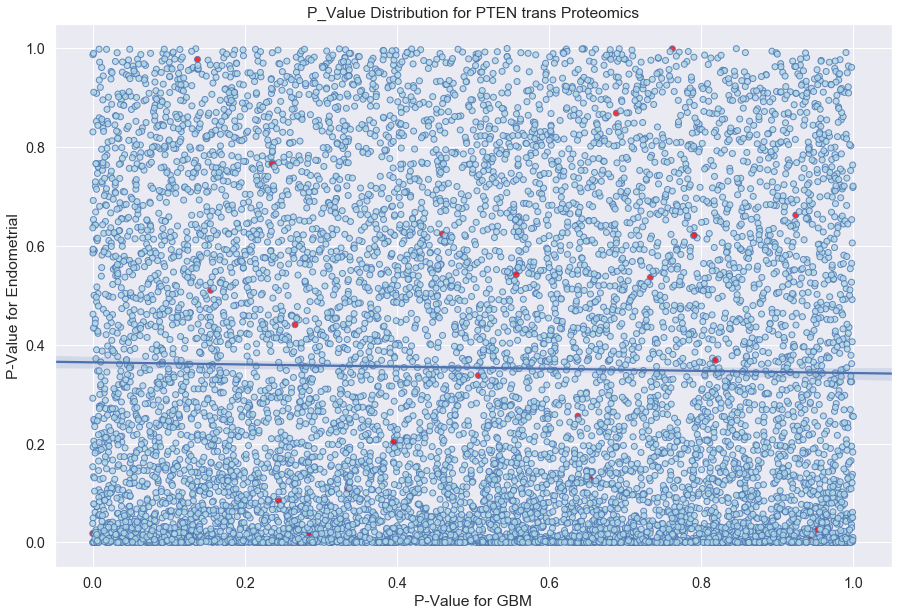

In [12]:
# Format figure size and font
plt.rcParams['figure.figsize']=(15,10)
sns.set(font_scale = 1.3)

# Format title and axis
plot = sns.regplot(x="P_Value_x", y="P_Value_y", data=both_values_df,
                   scatter_kws={'facecolors':both_values_df['color']})
plot.set_title("P_Value Distribution for "+gene+" trans Proteomics")
plot.set(xlabel = 'P-Value for '+cancer1)
plot.set(ylabel = 'P-Value for '+cancer2)

plt.show()
plt.clf()
plt.close()

Zoom x-axis (low endometrial p-values)

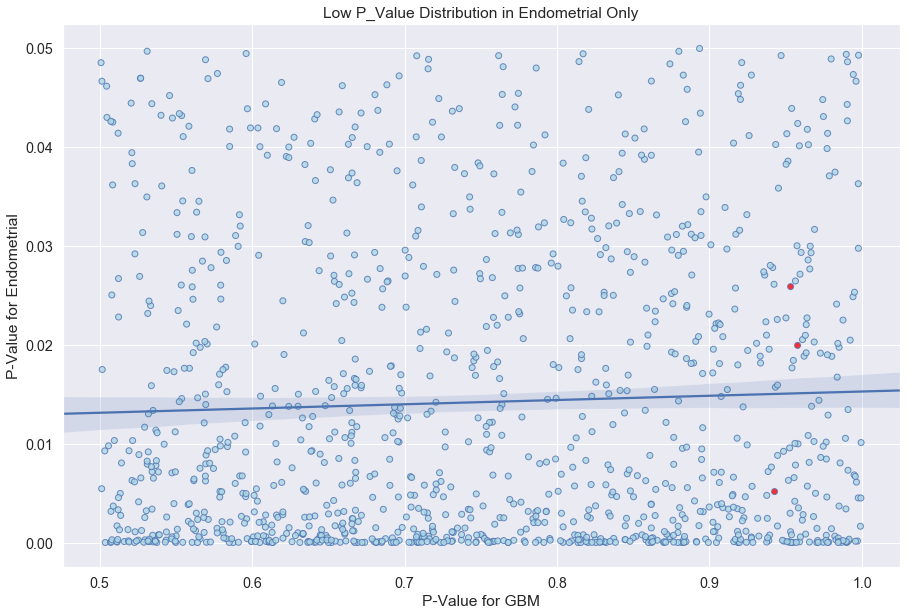

In [13]:
low_endo_pvals = both_values_df.loc[both_values_df['P_Value_y'] <= 0.05] #graph
low_endo_pvals = low_endo_pvals.loc[low_endo_pvals['P_Value_x'] >= 0.5]

# Format figure size and font
plt.rcParams['figure.figsize']=(15,10)
sns.set(font_scale = 1.3)

# Format title and axis
plot = sns.regplot(x="P_Value_x", y="P_Value_y", data=low_endo_pvals, 
                   scatter_kws={'facecolors':low_endo_pvals['color']})
plot.set_title("Low P_Value Distribution in Endometrial Only")
plot.set(xlabel = 'P-Value for '+cancer1)
plot.set(ylabel = 'P-Value for '+cancer2)

plt.show()
plt.clf()
plt.close()

Zoom y-axis (low gbm p-values)

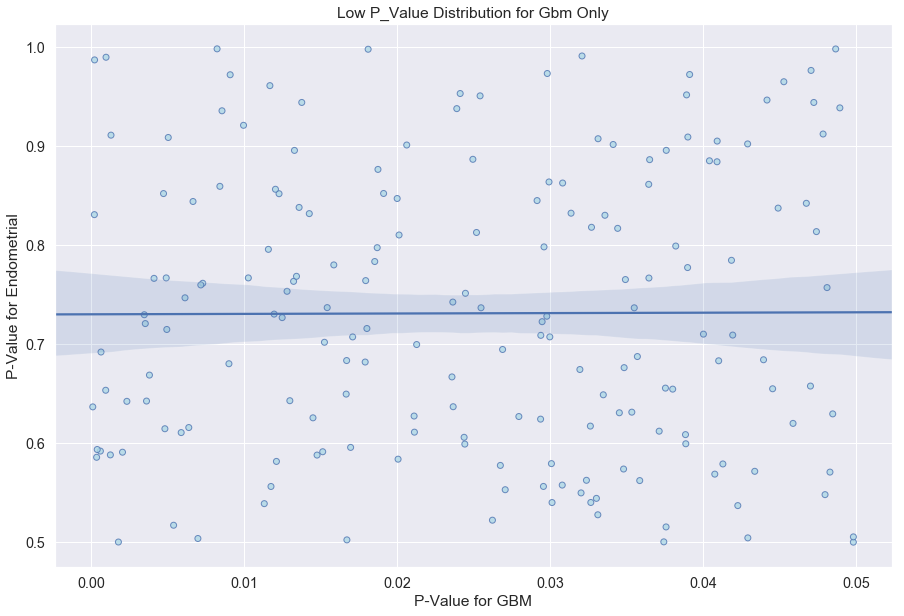

In [14]:
low_gbm_pvals = both_values_df.loc[both_values_df['P_Value_x'] <= 0.05]
low_gbm_pvals = low_gbm_pvals.loc[low_gbm_pvals['P_Value_y'] >= 0.5] #comment out to see all y

# Format figure size and font
plt.rcParams['figure.figsize']=(15,10)
sns.set(font_scale = 1.3)

# Format title and axis
plot = sns.regplot(x="P_Value_x", y="P_Value_y", data=low_gbm_pvals, scatter_kws={'facecolors':low_gbm_pvals['color']})
plot.set_title("Low P_Value Distribution for Gbm Only")
plot.set(xlabel = 'P-Value for '+cancer1)
plot.set(ylabel = 'P-Value for '+cancer2)

plt.show()
plt.clf()
plt.close()

# GSEA 

In [15]:
# corners for gsea test for zoomed x-axis (0-1 range gbm pvals)
low = combined.loc[combined['P_Value_y'] <= 0.05]
low_left_corner = low.loc[low['P_Value_x'] <= 0.05] 
low_right_corner = low.loc[low['P_Value_x'] >= 0.5] 

print("Number of both low:", len(low_left_corner))
print("Number of low endo, high gbm:", len(low_right_corner))

# corners for gsea test for zoomed y-axis (0-1 range endo pvals)
high = combined.loc[combined['P_Value_y'] >= 0.5] 
high_left_corner = high.loc[high['P_Value_x'] <= 0.05] 
high_right_corner = high.loc[high['P_Value_x'] >= 0.5]  
print("Number of high endo, low gbm:", len(high_left_corner))
print("Number of both high:", len(high_right_corner))

Number of both low: 131
Number of low endo, high gbm: 1159
Number of high endo, low gbm: 185
Number of both high: 1535


In [16]:
# gsea for lower left corner (both low pvals)
both_low_pvals = list(low_left_corner['Comparison'])
print("Number of genes for both low pvals:", len(both_low_pvals))

both_low_gsea = gp.enrichr(
    gene_list = both_low_pvals, description='Tumor_partition', gene_sets='KEGG_2016')

Number of genes for both low pvals: 131


2020-01-11 13:53:13,278 Warning: No enrich terms using library KEGG_2016 when cutoff = 0.05


In [17]:
both_low_gsea.res2d.head() # pip2 signaling? check phosphatidylinositol proteins!

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
0,Phosphatidylinositol signaling system Homo sap...,5/98,0.000466,0.136502,0,0,7.789375,59.756874,PPIP5K1;PIK3CA;PTEN;PIP5K1A;CDIPT,KEGG_2016
1,Central carbon metabolism in cancer Homo sapie...,4/67,0.000979,0.143464,0,0,9.114732,63.153182,LDHA;PIK3CA;ERBB2;PTEN,KEGG_2016
2,Inositol phosphate metabolism Homo sapiens hsa...,4/71,0.001217,0.118826,0,0,8.601226,57.728495,PIK3CA;PTEN;PIP5K1A;CDIPT,KEGG_2016
3,Small cell lung cancer Homo sapiens hsa05222,4/86,0.002466,0.180632,0,0,7.101012,42.642779,PIK3CA;PTEN;FN1;BCL2L1,KEGG_2016
4,Glycosaminoglycan biosynthesis - keratan sulfa...,2/15,0.004228,0.247741,0,0,20.356234,111.269298,CHST6;B4GALT4,KEGG_2016


In [18]:
# gsea for low right corner (low endo, high gbm)
low_endo_high_gbm = list(low_right_corner['Comparison'])
print("Number of genes for low_endo_high_gbm:", len(low_endo_high_gbm))

low_endo_high_gbm_gsea = gp.enrichr(
    gene_list = low_endo_high_gbm, description='Tumor_partition', gene_sets='KEGG_2016')

Number of genes for low_endo_high_gbm: 1159


In [19]:
g = low_endo_high_gbm_gsea.res2d.head()
#list(g['Genes'])
g

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
0,Spliceosome Homo sapiens hsa03040,35/134,2.452474e-14,7.185750e-12,0,0,4.507231,141.252532,TCERG1;SF3B2;SF3B3;EIF4A3;DDX23;HNRNPU;USP39;P...,KEGG_2016
1,Ribosome biogenesis in eukaryotes Homo sapiens...,22/89,4.844741e-09,7.097546e-07,0,0,4.265591,81.666331,UTP15;NOP56;WDR36;NOP58;UTP6;NXT1;WDR3;HEATR1;...,KEGG_2016
2,Sulfur relay system Homo sapiens hsa04122,6/10,6.416312e-06,6.266598e-04,0,0,10.353753,123.796380,MPST;CTU2;NFS1;CTU1;TST;URM1,KEGG_2016
3,Amino sugar and nucleotide sugar metabolism Ho...,12/48,1.349536e-05,9.885350e-04,0,0,4.314064,48.374309,CYB5R2;CYB5R1;CYB5R4;GMDS;HEXB;MPI;HEXA;GMPPA;...,KEGG_2016
4,Mismatch repair Homo sapiens hsa03430,8/23,2.782071e-05,1.630293e-03,0,0,6.002176,62.961203,RFC5;MSH6;RFC3;RFC4;LIG1;RFC1;MSH2;RFC2,KEGG_2016


Range 0-1 endo (upper corners)

In [20]:
# gsea for high left corner (high endo, low gbm)
high_endo_low_gbm = list(high_left_corner['Comparison'])
print("Number of genes for high_endo_low_gbm:", len(high_endo_low_gbm))

high_endo_low_gbm_gsea = gp.enrichr(
    gene_list = high_endo_low_gbm, gene_sets='KEGG_2016')


Number of genes for high_endo_low_gbm: 185


2020-01-11 13:53:25,417 Warning: No enrich terms using library KEGG_2016 when cutoff = 0.05


In [30]:
gbm = high_endo_low_gbm_gsea.res2d.head() # check focal adhesions, endocytosis pathways
gbm

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
0,Vitamin B6 metabolism Homo sapiens hsa00750,2/6,0.001246,0.364991,0,0,36.036036,241.011008,PDXK;AOX1,KEGG_2016
1,Focal adhesion Homo sapiens hsa04510,7/202,0.002797,0.409735,0,0,3.746321,22.025627,ACTN1;BCL2;RAPGEF1;FLNA;FLNC;MYL9;IGF1R,KEGG_2016
2,Endocytosis Homo sapiens hsa04144,7/259,0.010553,1.000000,0,0,2.921841,13.298336,EHD2;TGFB2;HGS;MVB12B;GRK6;CBL;IGF1R,KEGG_2016
3,Proteoglycans in cancer Homo sapiens hsa05205,6/203,0.011658,0.853922,0,0,3.195314,14.224878,TGFB2;FLNA;FLNC;EZR;CBL;IGF1R,KEGG_2016
4,Terpenoid backbone biosynthesis Homo sapiens h...,2/22,0.017409,1.000000,0,0,9.828010,39.810832,FDPS;GGPS1,KEGG_2016


In [22]:
# gsea for high right corner (high endo, high gbm)
both_high = list(high_right_corner['Comparison'])
print("Number of genes for both_high:", len(both_high))

both_high_gsea = gp.enrichr(
    gene_list = both_high, description='Tumor_partition', gene_sets='KEGG_2016')

Number of genes for both_high: 1535


In [23]:
both_high_gsea.res2d.head()

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
0,Phagosome Homo sapiens hsa04145,31/154,5.893687e-07,0.000173,0,0,2.622784,37.621780,ITGB1;STX12;NCF1;TUBAL3;NCF2;NCF4;CORO1A;ACTB;...,KEGG_2016
1,SNARE interactions in vesicular transport Homo...,12/34,4.458236e-06,0.000653,0,0,4.598582,56.658015,GOSR2;STX8;GOSR1;BNIP1;STX3;STX2;SEC22B;SNAP29...,KEGG_2016
2,Complement and coagulation cascades Homo sapie...,19/79,6.014621e-06,0.000587,0,0,3.133633,37.670396,F10;SERPIND1;SERPINC1;PROS1;SERPINF2;F2;KNG1;C...,KEGG_2016
3,Viral myocarditis Homo sapiens hsa05416,16/59,6.186794e-06,0.000453,0,0,3.533374,42.376083,HLA-DRB4;LAMA2;ACTB;CASP9;HLA-DMA;CASP8;HLA-DM...,KEGG_2016
4,HTLV-I infection Homo sapiens hsa05166,39/258,3.557705e-05,0.002085,0,0,1.969548,20.175673,ATF2;SRF;PDGFA;XIAP;ADCY6;ANAPC11;HLA-DMA;NRAS...,KEGG_2016


Pathways

In [24]:
focal_adhesions_str = "ACTN1;BCL2;RAPGEF1;FLNA;FLNC;MYL9;IGF1R"
focal_adhesions = focal_adhesions_str.split(';')

combined["color"] = np.where(combined["Comparison"].isin(focal_adhesions), "purple", "lightblue")
print(focal_adhesions)
pathway_df = combined.dropna(axis=0, how='any') # only keep rows with both data points
pathway_df

['ACTN1', 'BCL2', 'RAPGEF1', 'FLNA', 'FLNC', 'MYL9', 'IGF1R']


,Comparison,P_Value_x,P_Value_y,color
0,PTEN,0.000032,0.018255,lightblue
1,CALD1,0.000227,0.831139,lightblue
2,FLNC,0.000240,0.987449,purple
3,ERBB2,0.000491,0.000164,lightblue
4,MAPK8IP3,0.000499,0.000446,lightblue
...,...,...,...,...
9792,METTL26,0.997759,0.049312,lightblue
9793,ZNF207,0.998493,0.406304,lightblue
9794,POLB,0.999058,0.050598,lightblue
9795,TIMM21,0.999198,0.182861,lightblue


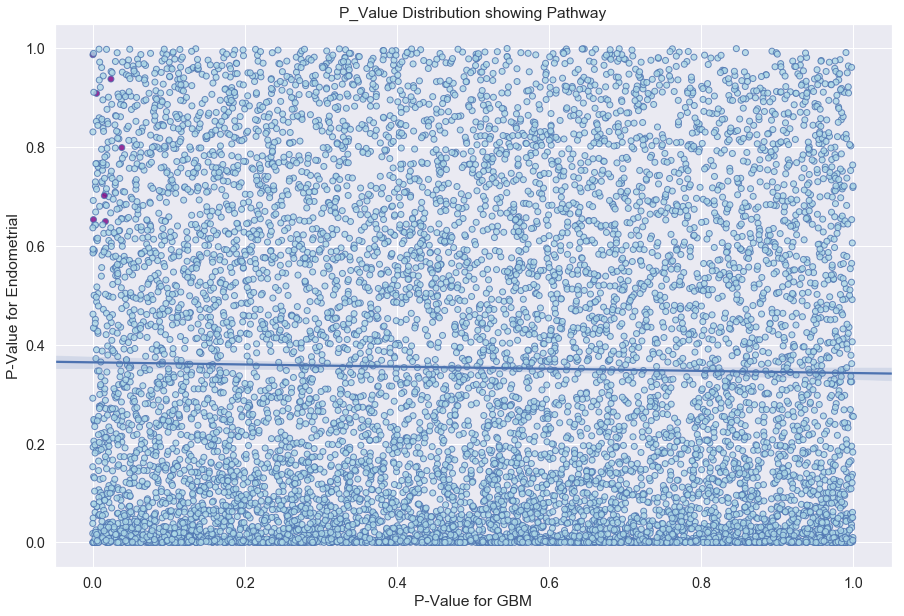

In [25]:
# Format figure size and font
plt.rcParams['figure.figsize']=(15,10)
sns.set(font_scale = 1.3)

# Format title and axis
plot = sns.regplot(x="P_Value_x", y="P_Value_y", data=pathway_df, 
                   scatter_kws={'facecolors':pathway_df['color']})
plot.set_title("P_Value Distribution showing Pathway")
plot.set(xlabel = 'P-Value for '+cancer1)
plot.set(ylabel = 'P-Value for '+cancer2)

plt.show()
plt.clf()
plt.close()